# SABR Model Test Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import imp
import numpy as np
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf
import option_models as opt

np.set_printoptions(precision=3)

/var/folders/5w/kzd6klcd6b7g536lbknh745m0000gn/T/ipykernel_12029/2495671279.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


## 1. Pricing using Hagan's formula (provided)

### (1) SABR for $0<\beta\le 1$

In [3]:
# Parameters
strike = np.linspace(75,125,num=25)
forward = 100
sigma = 0.2
texp = 1
vov = 0.5
rho = 0.25
beta = 1

In [4]:
# Create model
sabr_bsm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=beta)
#sabr_bsm.__dict__

In [5]:
# This is how you price. you can get either price or bsm_vol
price = sabr_bsm.price(strike, forward, texp)
bsm_vol = sabr_bsm.vol_smile(strike, forward, texp)

price, bsm_vol

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([0.204, 0.203, 0.202, 0.201, 0.2  , 0.2  , 0.2  , 0.2  , 0.201,
        0.202, 0.203, 0.204, 0.205, 0.206, 0.208, 0.21 , 0.211, 0.213,
        0.215, 0.217, 0.219, 0.221, 0.223, 0.225, 0.227]))

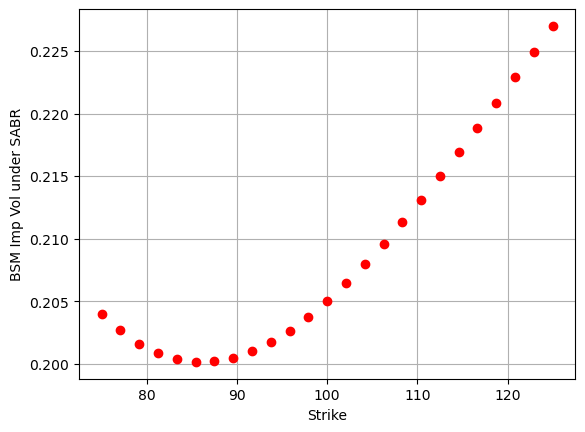

In [6]:
# volatility smile plot: try with different parameters
plt.plot(strike, bsm_vol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('BSM Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (2) SABR for $\beta=0$

In [7]:
strike = np.linspace(75,125,num=25)
#strike = 1
forward = 100
sigma = 20
texp = 1
alpha = 0.5
rho = -0.25

In [8]:
sabr_norm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=0)
price = sabr_norm.price(strike, forward, texp)
nvol = sabr_norm.vol_smile(strike, forward, texp, model='norm')

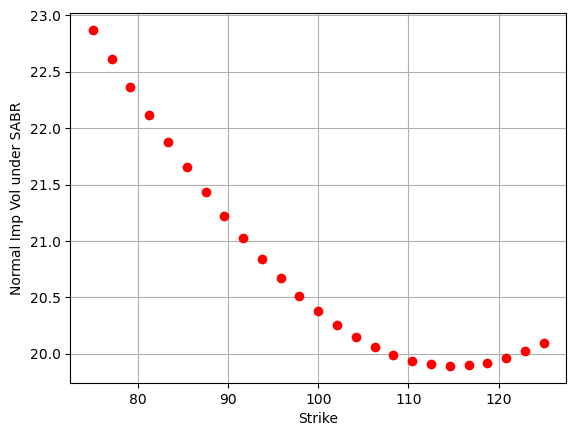

In [9]:
plt.plot(strike, nvol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('Normal Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (3) Smile calibration to 3 options

In [10]:
strike3 = np.array([90, 100, 110])
price3 = sabr_bsm.price(strike3, forward, texp)
vol3 = sabr_bsm.vol_smile(strike3, forward, texp)

price3, vol3

(array([13.608,  8.165,  4.769]), array([0.201, 0.205, 0.213]))

In [11]:
sabr_bsm.__dict__

{'sigma': 0.2,
 'intr': 0.0,
 'divr': 0.0,
 'is_fwd': False,
 'vov': 0.5,
 'rho': 0.25,
 'beta': 1}

In [12]:
# make sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(vol3, strike3, forward, texp, is_vol=True)

{'sigma': 0.20000000000010057,
 'vov': 0.4999999998672819,
 'rho': 0.24999999998257713}

In [13]:
# make sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(price3, strike3, forward, texp, is_vol=False)

{'sigma': 0.2000000000001018,
 'vov': 0.49999999986711535,
 'rho': 0.24999999998256825}

## 2. Pricing under MC method

In [14]:
strike = np.linspace(75,125,num=25)
forward = 100

In [15]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [16]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([26.028, 24.146, 22.322, 20.547, 18.854, 17.233, 15.702, 14.255,
        12.888, 11.628, 10.466,  9.391,  8.391,  7.474,  6.631,  5.874,
         5.211,  4.63 ,  4.12 ,  3.673,  3.276,  2.928,  2.625,  2.362,
         2.12 ]))

Repeat the same for beta = 0

In [17]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_mc = opt.sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [18]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([27.485, 25.611, 23.765, 21.97 , 20.229, 18.53 , 16.874, 15.282,
        13.762, 12.323, 10.957,  9.67 ,  8.47 ,  7.353,  6.339,  5.422,
         4.618,  3.902,  3.273,  2.736,  2.288,  1.912,  1.588,  1.316,
         1.082]))

## 3. Pricing under conditional MC method

In [19]:
strike = np.linspace(75,125,num=25)
forward = 100

In [20]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_cmc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [21]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_cmc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([25.424, 23.544, 21.718, 19.954, 18.261, 16.648, 15.121, 13.688,
        12.351, 11.114,  9.976,  8.937,  7.992,  7.138,  6.37 ,  5.681,
         5.066,  4.517,  4.029,  3.595,  3.21 ,  2.869,  2.566,  2.298,
         2.06 ]))

Repeat the same for beta = 0

In [22]:
####
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_cmc = opt.sabr.ModelBsmCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
#                             ^^^
####

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [23]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_cmc = opt.sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [24]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_cmc.price(strike, forward, texp)
    
# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([26.582, 24.743, 22.942, 21.182, 19.47 , 17.81 , 16.209, 14.672,
        13.205, 11.813, 10.503,  9.277,  8.14 ,  7.094,  6.14 ,  5.279,
         4.507,  3.824,  3.223,  2.701,  2.25 ,  1.865,  1.539,  1.264,
         1.035]))

## Compare the MC variance between brute-force MC and conditional MC
For this, you should not use the random number seed

In [25]:
def compare_MC_and_CMC(m_repeat=100, bsm=True):
    res_MC = np.zeros(m_repeat)
    res_CMC = np.zeros(m_repeat)
    if bsm:
        sabr_bsm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
        sabr_bsm_cmc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
        for k in range(0,m_repeat):
            res_MC[k] = sabr_bsm_mc.price([strike[0]], forward, texp)
            res_CMC[k] = sabr_bsm_cmc.price([strike[0]], forward, texp)
            
    else:
        sabr_norm_mc = opt.sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
        sabr_norm_cmc = opt.sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)            
        for k in range(0,m_repeat):
            res_MC[k] = sabr_norm_mc.price([strike[0]], forward, texp)
            res_CMC[k] = sabr_norm_cmc.price([strike[0]], forward, texp)
        
    return ([np.mean(res_MC), np.std(res_MC)], [np.mean(res_CMC), np.std(res_CMC)])

results_bsm = compare_MC_and_CMC()
results_norm = compare_MC_and_CMC(bsm=False)

print(f'BSM:')
print(f"The mean of MC is {results_bsm[0][0]:0.3f} and the std is {results_bsm[0][1]:0.3f}")
print(f"The mean of CMC is {results_bsm[1][0]:0.3f} and the std is {results_bsm[1][1]:0.3f}")
print(f'Normal:')
print(f"The mean of MC is {results_norm[0][0]:0.3f} and the std is {results_norm[0][1]:0.3f}")
print(f"The mean of CMC is {results_norm[1][0]:0.3f} and the std is {results_norm[1][1]:0.3f}")

BSM:
The mean of MC is 25.624 and the std is 0.668
The mean of CMC is 25.628 and the std is 0.193
Normal:
The mean of MC is 26.665 and the std is 0.543
The mean of CMC is 26.558 and the std is 0.092
